<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-Study:-Northwind-Traders" data-toc-modified-id="Case-Study:-Northwind-Traders-1">Case Study: Northwind Traders</a></span><ul class="toc-item"><li><span><a href="#convert-sql-database-tables-into-pandas-dataframes" data-toc-modified-id="convert-sql-database-tables-into-pandas-dataframes-1.1">convert sql database tables into pandas dataframes</a></span><ul class="toc-item"><li><span><a href="#check-for-normality-in-the-experiment-and-control-samples" data-toc-modified-id="check-for-normality-in-the-experiment-and-control-samples-1.1.1">check for normality in the experiment and control samples</a></span></li></ul></li><li><span><a href="#Question-1:" data-toc-modified-id="Question-1:-1.2">Question 1:</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-1.3">Question 2</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Is-there-a-region-that-outperforms-the-others-in-terms-of-order-quantities?" data-toc-modified-id="Is-there-a-region-that-outperforms-the-others-in-terms-of-order-quantities?-1.3.0.1">Is there a region that outperforms the others in terms of order quantities?</a></span></li></ul></li><li><span><a href="#check-for-normality" data-toc-modified-id="check-for-normality-1.3.1">check for normality</a></span><ul class="toc-item"><li><span><a href="#stats-normaltest-confirms-the-distributions-are-not-normalLets-re-sample-to-gather-distribution-means-that-will-satisfy-normality-assumptions" data-toc-modified-id="stats-normaltest-confirms-the-distributions-are-not-normalLets-re-sample-to-gather-distribution-means-that-will-satisfy-normality-assumptions-1.3.1.1">stats normaltest confirms the distributions are not normal<br>Lets re-sample to gather distribution means that will satisfy normality assumptions</a></span></li></ul></li><li><span><a href="#combining-multiple-Series-into-a-DataFrame:-lessons-learned----the-Series-must-have-names-(see-example-above)and-you-must-specify-the-horizontal-axis" data-toc-modified-id="combining-multiple-Series-into-a-DataFrame:-lessons-learned----the-Series-must-have-names-(see-example-above)and-you-must-specify-the-horizontal-axis-1.3.2">combining multiple Series into a DataFrame: <br>lessons learned -- the Series must have names (see example above)<br>and you must specify the horizontal axis</a></span></li><li><span><a href="#need-to-run-ANOVA-here" data-toc-modified-id="need-to-run-ANOVA-here-1.3.3">need to run ANOVA here</a></span></li></ul></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-1.4">Question 3</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#are-there-any-salespeople-that-stand-out?" data-toc-modified-id="are-there-any-salespeople-that-stand-out?-1.4.0.1">are there any salespeople that stand out?</a></span></li></ul></li></ul></li><li><span><a href="#Question-4" data-toc-modified-id="Question-4-1.5">Question 4</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#are-there-any-categories-we-should-think-about-dicontinuing-or-expanding-on?" data-toc-modified-id="are-there-any-categories-we-should-think-about-dicontinuing-or-expanding-on?-1.5.0.1">are there any categories we should think about dicontinuing or expanding on?</a></span></li></ul></li></ul></li></ul></li></ul></div>

[link to cell in question](#link_to_cell_in_question)

[link to pd.melt](#link_to_pd.melt)


# Case Study: Northwind Traders


Four questions to consider:<br>
1. Do discounted items sell in greater quantites than non-discounted items?  And if so, does the level of discount have an impact?
2. Are there any days per week within each reagion that stand out?
3. Do all regions perform equally in terms of quantities sold?  And are there any products that differ in quanitty sold by region?
4. Are all salespeople created equal or do we have any under/over-performers?  And does time in job play a role?


In [1]:
# import packages and modules


import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import scipy.stats as stats
from math import sqrt
import math
import copy
import statsmodels.api as sm             #for ANOVA
from statsmodels.formula.api import ols  #for ANOVA
from sklearn import preprocessing

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import session, sessionmaker
from sqlalchemy import inspect # so we can perform high level investigations


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn')
from matplotlib import style

pd.set_option('display.max_columns', None)

In [2]:
# creating an engine object and a session to connect and work with the Northwind sql db

engine = create_engine("sqlite:///Northwind_small.sqlite", echo = True)
Session = sessionmaker(bind = engine)
session = Session
inspector = inspect(engine)

2019-05-19 11:29:16,179 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-19 11:29:16,184 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:16,186 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-19 11:29:16,187 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# lets have a look at the tables we will be working with and get to know them better

inspector.get_table_names()

2019-05-19 11:29:17,404 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-19 11:29:17,405 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [4]:


from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base # creates a framework that clones the db structure so that it can generate a 
                                                  # a new model in which to map the db with its metadata, ie, column headings

In [5]:
# map the db table features with their headings

metadata = MetaData()
metadata.reflect(engine)
Base = automap_base(metadata = metadata)
Base.prepare()

Category, Customer, CustomerCustomerDemo, CustomerDemographic, Employee, EmployeeTerritory, Order, OrderDetail,\
Product, Region, Shipper, Supplier, Territory = \
Base.classes.Category,\
Base.classes.Customer,\
Base.classes.CustomerCustomerDemo,\
Base.classes.CustomerDemographic, \
Base.classes.Employee, \
Base.classes.EmployeeTerritory,\
Base.classes.Order,\
Base.classes.OrderDetail, \
Base.classes.Product, \
Base.classes.Region,\
Base.classes.Shipper, \
Base.classes.Supplier, \
Base.classes.Territory

2019-05-19 11:29:20,070 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-19 11:29:20,071 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:20,075 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-05-19 11:29:20,076 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:20,079 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-05-19 11:29:20,080 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:20,082 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Category")
2019-05-19 11:29:20,083 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:20,084 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-05-19 11:29:20,085 INFO sqlalchemy.engine.base.Engin

##### converting each mapped table to a pandas dataframe

In [6]:
# converting each mapped table to a pandas dataframe

category_df= pd.read_sql_query("SELECT * FROM [category]", engine)
customer_df = pd.read_sql_query("SELECT * FROM [customer]", engine)
customerCustomerDemo_df = pd.read_sql_query("SELECT * FROM [customerCustomerDemo]", engine)
customerDemographic_df = pd.read_sql_query("SELECT * FROM [customerDemographic]", engine)
employee_df = pd.read_sql_query("SELECT * FROM [employee]", engine)
employeeTerritory_df = pd.read_sql_query("SELECT * FROM [employeeTerritory]", engine)
order_df = pd.read_sql_query("SELECT * FROM [order]", engine)
orderDetail_df = pd.read_sql_query("SELECT * FROM [orderDetail]", engine)
product_df = pd.read_sql_query("SELECT * FROM [product]", engine)
region_df = pd.read_sql_query("SELECT * FROM [region]", engine)
shipper_df = pd.read_sql_query("SELECT * FROM [shipper]", engine)
supplier_df = pd.read_sql_query("SELECT * FROM [supplier]", engine)
territory_df = pd.read_sql_query("SELECT * FROM [territory]", engine)

2019-05-19 11:29:22,301 INFO sqlalchemy.engine.base.Engine SELECT * FROM [category]
2019-05-19 11:29:22,302 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:22,308 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customer]
2019-05-19 11:29:22,308 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:22,316 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customerCustomerDemo]
2019-05-19 11:29:22,317 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:22,321 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customerDemographic]
2019-05-19 11:29:22,322 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:22,326 INFO sqlalchemy.engine.base.Engine SELECT * FROM [employee]
2019-05-19 11:29:22,327 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:22,334 INFO sqlalchemy.engine.base.Engine SELECT * FROM [employeeTerritory]
2019-05-19 11:29:22,335 INFO sqlalchemy.engine.base.Engine ()
2019-05-19 11:29:22,341 INFO sqlalchemy.engine.base.Engine SELECT * FROM [order]
2019-05-19 

In [7]:
# combining all the newly converted tables into one go-to DataFrame

category_df.rename(columns = {"Id":"CategoryId"}, inplace = True)
cat_prod_df = pd.merge(category_df, product_df, on = "CategoryId" )
cat_prod_df.rename(columns = {"Id": "ProductId"}, inplace = True)
cat_prod_OrDtl_df = pd.merge(cat_prod_df, orderDetail_df, on = "ProductId")
order_df.rename(columns = {"Id" : "OrderId"}, inplace = True)
cat_prod_OrDtl_orders_df = pd.merge(cat_prod_OrDtl_df, order_df, on = "OrderId" )
customer_df.rename(columns ={"Id": "CustomerId"}, inplace = True)
data = pd.merge(cat_prod_OrDtl_orders_df, customer_df, on = "CustomerId")
data.head()

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,14.4,45,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
1,6,Meat/Poultry,Prepared meats,53,Perth Pasties,24,48 pieces,32.8,0,0,0,1,10285/53,10285,26.2,36,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
2,8,Seafood,Seaweed and fish,40,Boston Crab Meat,19,24 - 4 oz tins,18.4,123,0,30,0,10285/40,10285,14.7,40,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
3,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10691/1,10691,18.0,30,0.0,QUICK,2,2013-10-03,2013-11-14,2013-10-22,2,810.05,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
4,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",43,Ipoh Coffee,20,16 - 500 g tins,46.0,17,10,25,0,10691/43,10691,46.0,40,0.0,QUICK,2,2013-10-03,2013-11-14,2013-10-22,2,810.05,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None


## <font color='lime'> Question 1 </font>
###### Do discounted items sell in greater quantites than non-discounted items?  And if so, does the level of discount have an impact?

##### Isolate the data we need 

In [8]:
# we will need Quanity and Discount columns to answer both parts of quesiotn 1

q1df = copy.deepcopy(orderDetail_df[["Quantity", "Discount"]])
q1df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [9]:
q1df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [10]:
# remove irrelevant discount levels based on the extremely low number of observations

q1df = copy.deepcopy(q1df[q1df.Discount.isin([ 0.05, 0.10, 0.20, 0.15, 0.25, 0.00])])

In [11]:
# check for null values

q1df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2147 non-null int64
Discount    2147 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


##### Lets check for normality visually and with statistical tests 

In [12]:
# split the data between the control (no discount) and experiment group (having a discount)

q1_wDis = copy.deepcopy(q1df[q1df.Discount > 0.0])
q1_woDis = copy.deepcopy(q1df[q1df.Discount == 0.0])

print("number observations without discount:", len(q1_woDis))
print("number observations with discount :", len(q1_wDis))

wDisAvg = q1_wDis['Quantity'].mean()
print("avg. quantity sold with discount:" , wDisAvg)

wOdisAvg = q1_woDis['Quantity'].mean()
print("avg. quantity sold without a discount:" , wOdisAvg)

number observations without discount: 1317
number observations with discount : 830
avg. quantity sold with discount: 27.35421686746988
avg. quantity sold without a discount: 21.715261958997722


##### Visual checks for normality 

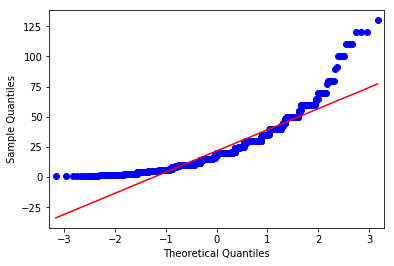

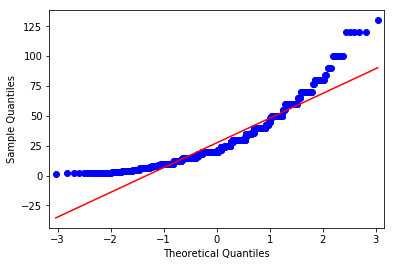

In [13]:
from statsmodels.graphics.gofplots import qqplot

wo_dis = qqplot(q1_woDis.Quantity, line = 's')
w_dis=qqplot(q1_wDis.Quantity, line = 's')

##### The Quanitle Quantile (QQ) plots above for the experiment and control group show a large deviation from the ideal normal distribution (the straight line). 

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


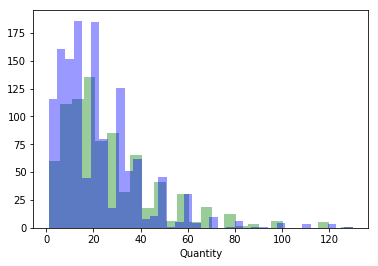

In [14]:
# kde turned off so we see actual frequency instead of normalized frequency

sns.distplot(q1_wDis.Quantity, kde = False, color = 'g', label = "w discount")
sns.distplot(q1_woDis.Quantity, kde = False, color = 'b', label = "wo discount")

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


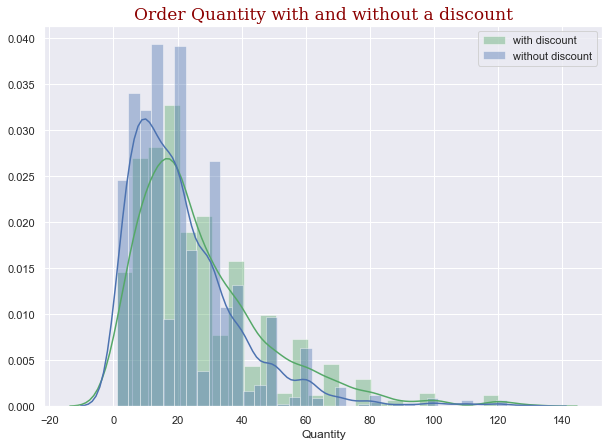

In [15]:
#plt.style.use("dark_background")
#sns.set_color_codes("bright")
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(q1_wDis.Quantity, color = "g", label = "with discount", norm_hist = False) 
sns.distplot(q1_woDis.Quantity, color = "b", label = "without discount", norm_hist = False) 

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }

plt.title("Order Quantity with and without a discount", fontdict=font)
plt.legend()

###### The qq plots and historgrams look non-normal; lets conifrm with the stats normaltest method which performs a D'Aostino K**2 test that looks at skew (asymetry) and kurtosis (magnitude of observations present in a tail)

In [16]:
print(stats.normaltest(q1_wDis.Quantity))
print(stats.normaltest(q1_woDis.Quantity))

NormaltestResult(statistic=261.04626710761113, pvalue=2.0631145260149106e-57)
NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)


##### P-value for both sets is less than alpha of 0.05 so we reject the null that distribution is normal. <br> Now lets focus on getting our samples to fit a normal distribution<br>we will use the property of the Central Limit Theorem and sampling distribution of the mean

In [17]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def create_sample_distribution(data, dist_size=2000, n=500):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = sum(sample) / len(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist




In [22]:
q1_norm_wDis = pd.Series(create_sample_distribution(q1_wDis.Quantity))
q1_norm_woDis = pd.Series(create_sample_distribution(q1_woDis.Quantity))

###### now lets visually inspect the distribution of sample means for the control and experiment groups

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


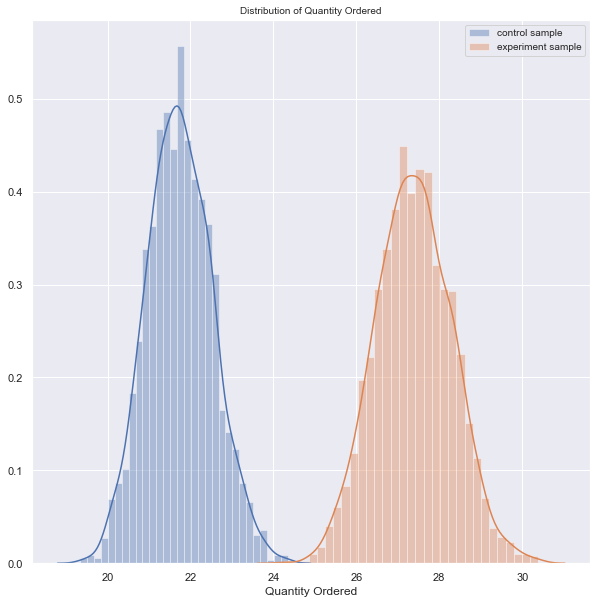

In [20]:
plt.figure(figsize = (10,10))
sns.distplot(q1_norm_woDis, label = "control sample")
sns.distplot(q1_norm_wDis, label = "experiment sample")
plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [23]:
print(stats.normaltest(q1_norm_woDis))
print(stats.normaltest(q1_norm_wDis))

NormaltestResult(statistic=3.3941074368972566, pvalue=0.18322255482768002)
NormaltestResult(statistic=2.107568181716439, pvalue=0.34861605515595345)


##### running a normal test on the new data we see we fail to reject the null that the distributions are normal <br> Our data now satisfies the normality assumption. 

## Question 1: 
##### Does offering a discount precipitate a meaningful difference in order quantity?<br> And if so, is there a discount level that stands out from the rest?

question 1 part a

$H_O$: Offering a discount does not change the average order quantity<br>
$H_a$: Products having a discount are ordered in greater quantities compared to those not having a discount<br>

this is a one tail test

In [24]:
# Run a T-test

#print(stats.ttest_ind(q1_wDis.Quantity, q1_woDis.Quantity , equal_var = False))

print(stats.ttest_ind(q1_norm_wDis, q1_norm_woDis , equal_var = False))


Ttest_indResult(statistic=208.37255527493014, pvalue=0.0)


In [29]:
print(type(q1_norm_wDis))
q1_norm_wDis.mean()

<class 'pandas.core.series.Series'>


27.366015

In [30]:
print(type(q1_norm_woDis))
q1_norm_woDis.mean()

<class 'pandas.core.series.Series'>


21.707873

In [33]:
print("avg. quantity sold with discount:" , q1_norm_wDis.mean())
print("avg. quantity sold without a discount:" , q1_norm_woDis.mean())
print("difference in avg. quantity sold (simple effect size):", round(q1_norm_wDis.mean() - q1_norm_woDis.mean(),0) )
print("relative to not using a discount, discounted items increase quanties sold by {} percent on avearge" .format(round(((q1_norm_wDis.mean() - q1_norm_woDis.mean())/q1_norm_woDis.mean())*100),1))

#print("Effect size: ", round(discount['Quantity'].mean() - no_discount['Quantity'].mean(),1))
#print("Relative effect size: ", round((discount['Quantity'].mean() - no_discount['Quantity'].mean())/no_discount['Quantity'].mean(),2))

avg. quantity sold with discount: 27.366015
avg. quantity sold without a discount: 21.707873
difference in avg. quantity sold (simple effect size): 6.0
relative to not using a discount, discounted items increase quanties sold by 26.0 percent on avearge


#####  <font color='yellow'> Conclusion part 1a </font>
Our P-value and T-score tell us we can confidently reject the null hypothsis (P value is less than alpha and T score is greater than critical value of 1.96) so we now know that the sample means are different and that we can trust the results of the test to a statistically significant degree.

###### Question 1 part b

for the next part of the question, we will dig a bit deeper to determine if there is a certain level of discount that precipitates an increase in order size, or not

will separate/bin the discount levels so we can compare each experiment group to the control

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


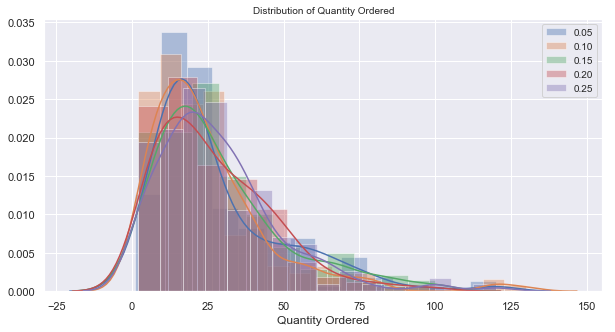

In [34]:


plt.figure(figsize = (10,5))

sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.05], label = "0.05")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.10], label = "0.10")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.15], label = "0.15")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.20], label = "0.20")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.25], label = "0.25")



plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [36]:
q1a_feature_groups = [ 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.05], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.10], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.15], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.20], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.25] 
                     ]


for i in q1a_feature_groups:
    print(stats.normaltest(i))

NormaltestResult(statistic=63.84242740591745, pvalue=1.3702286160643066e-14)
NormaltestResult(statistic=98.50271035413209, pvalue=4.0776337983848464e-22)
NormaltestResult(statistic=38.52550343019272, pvalue=4.308173885400061e-09)
NormaltestResult(statistic=31.398997154435623, pvalue=1.519827852850104e-07)
NormaltestResult(statistic=54.44887806745976, pvalue=1.5016763972075847e-12)


groups of the different discount levels are not Gaussian

In [59]:

df_05 = q1df[q1df.Discount == 0.05]
df_10 = q1df[q1df.Discount == 0.10]
df_15 = q1df[q1df.Discount == 0.15]
df_20 = q1df[q1df.Discount == 0.20]
df_25 = q1df[q1df.Discount == 0.25]


norm_05 = create_sample_distribution(df_05.Quantity, dist_size=1000, n=1000)
norm_10 = create_sample_distribution(df_10.Quantity, dist_size=1000, n=1000)
norm_15 = create_sample_distribution(df_15.Quantity, dist_size=1000, n=1000)
norm_20 = create_sample_distribution(df_20.Quantity, dist_size=1000, n=1000)
norm_25 = create_sample_distribution(df_25.Quantity, dist_size=1000, n=1000)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


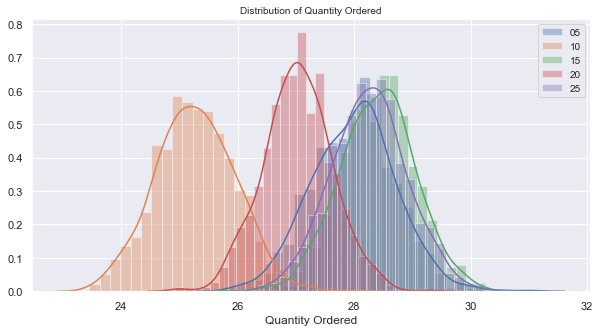

In [60]:
plt.figure(figsize = (10,5))


sns.distplot(norm_05, label = "05")
sns.distplot(norm_10, label = "10")
sns.distplot(norm_15, label = "15")
sns.distplot(norm_20, label = "20")
sns.distplot(norm_25, label = "25")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [62]:
norm_levels = [norm_05, norm_10, norm_15, norm_20, norm_25]

for level in norm_levels:
    print(stats.normaltest(level))

NormaltestResult(statistic=4.335493832424174, pvalue=0.11443515867107476)
NormaltestResult(statistic=1.5849879547379313, pvalue=0.45271432690113067)
NormaltestResult(statistic=2.0316316056619956, pvalue=0.36210690146710156)
NormaltestResult(statistic=2.2627803753449554, pvalue=0.32258449157732644)
NormaltestResult(statistic=0.2530095166256948, pvalue=0.8811699566512146)


In [63]:
# converting the lists of resampled quantities into series


norm_05=pd.Series( norm_05, name= 'norm_05')
norm_10=pd.Series( norm_10, name= 'norm_10')
norm_15=pd.Series( norm_15, name= 'norm_15')
norm_20=pd.Series( norm_20, name= 'norm_20')
norm_25=pd.Series(norm_25, name= 'norm_25')

# combining the series into a dataFrame
norm_dis_df = pd.DataFrame(pd.concat([norm_05, norm_10, norm_15, norm_20, norm_25], axis = 1))

# using .melt() to change the datas structure into one that will allow me to compute ANOVA
norm_discount_melted_df = copy.deepcopy(pd.melt(norm_dis_df))

# renaming column names to be intuitive
norm_discount_melted_df.rename(columns = {'variable': 'Discount', 'value': 'Quantity'}, inplace=True)

#norm_discount_melted_df.replace({'Discount':{'norm_05':0.05, 'norm_10':0.10, 'norm_15':0.15, 'norm_20':0.20, 'norm_25':0.25}}, inplace = True)
norm_discount_melted_df.head()

,Discount,Quantity
0,norm_05,28.945
1,norm_05,27.566
2,norm_05,27.136
3,norm_05,27.782
4,norm_05,27.947


ANOVA Table

In [64]:
formula = "Quantity ~ C(Discount)"
           
lm = ols(formula, q1_wDis).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                    sum_sq     df         F    PR(>F)
C(Discount)    1159.517551    4.0  0.674103  0.610041
Residual     354768.342690  825.0       NaN       NaN


###### The ANOVA F statistic is not in the rejection region, being less than the critical value of 2.57, however, the P-value is insignificant, so we fail to reject the null that the magnitude of impact between the varying discount levels on quantities sold are equal.  

##### <font color='yellow'> Conclusion part 1b </font>

**Restate the question and hypotheses:**<br>
is there a difference in magnitude of impact on order quantities between the varying discount levels?<br>
𝐻𝑂: All discount groups have an equal impact on order quantities<br>
𝐻𝑎: Varying discount levels produce different results on order quantities<br>

There is no significant difference in order quantities between the different disscount levels.
The implication of this conclusion is that Northwind can achieve the same results with a 5% discount as a 25% discount, so, they should use the less expensive discount to buy demand.

## <font color ='lime'> Question 2 </font>
###### Are order quantities equivalent regions by day of the week?

$H_O$: Order quantities are uniform between days of the week in a given region<br>
$H_a$: Order quantities vary with significance between days of the week in a given region<br>

this is a two tailed test

In [102]:
data.head()

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,14.4,45,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
1,6,Meat/Poultry,Prepared meats,53,Perth Pasties,24,48 pieces,32.8,0,0,0,1,10285/53,10285,26.2,36,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
2,8,Seafood,Seaweed and fish,40,Boston Crab Meat,19,24 - 4 oz tins,18.4,123,0,30,0,10285/40,10285,14.7,40,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
3,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10691/1,10691,18.0,30,0.0,QUICK,2,2013-10-03,2013-11-14,2013-10-22,2,810.05,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
4,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",43,Ipoh Coffee,20,16 - 500 g tins,46.0,17,10,25,0,10691/43,10691,46.0,40,0.0,QUICK,2,2013-10-03,2013-11-14,2013-10-22,2,810.05,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None


In [103]:
q2df = copy.deepcopy(data[["Region", "Quantity", "OrderDate"]])
q2df.head()


,Region,Quantity,OrderDate
0,Western Europe,45,2012-08-20
1,Western Europe,36,2012-08-20
2,Western Europe,40,2012-08-20
3,Western Europe,30,2013-10-03
4,Western Europe,40,2013-10-03


In [104]:
q2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078 entries, 0 to 2077
Data columns (total 3 columns):
Region       2078 non-null object
Quantity     2078 non-null int64
OrderDate    2078 non-null object
dtypes: int64(1), object(2)
memory usage: 64.9+ KB


In [105]:
# we need to convert the OrderDate column from a string (object) to a DateTime type.

q2df.OrderDate = pd.to_datetime(q2df.OrderDate, infer_datetime_format=True)
q2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078 entries, 0 to 2077
Data columns (total 3 columns):
Region       2078 non-null object
Quantity     2078 non-null int64
OrderDate    2078 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 64.9+ KB


In [106]:
q2df['DayOfWeek'] = q2df['OrderDate'].dt.day_name()
q2df.head()

,Region,Quantity,OrderDate,DayOfWeek
0,Western Europe,45,2012-08-20,Monday
1,Western Europe,36,2012-08-20,Monday
2,Western Europe,40,2012-08-20,Monday
3,Western Europe,30,2013-10-03,Thursday
4,Western Europe,40,2013-10-03,Thursday


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


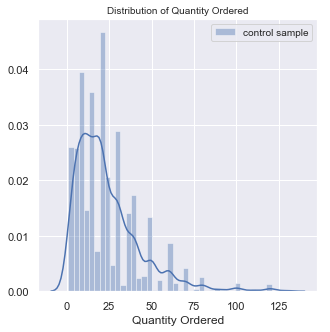

In [107]:
plt.figure(figsize = (5,5))
sns.distplot(q2df.Quantity, label = "control sample")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

will need to resample, but first, split data by features

In [108]:
q2df.Region.unique()

array(['Western Europe', 'North America', 'Central America',
       'Southern Europe', 'Scandinavia', 'Eastern Europe',
       'British Isles', 'Northern Europe', 'South America'], dtype=object)

In [116]:
q2df.DayOfWeek.unique()

array(['Monday', 'Thursday', 'Tuesday', 'Sunday', 'Wednesday'],
      dtype=object)

Lets isolate Region and Quantity so we can answer our second question

In [39]:
q2df.head(15)

,Region,Quantity
0,Western Europe,45
1,Western Europe,36
2,Western Europe,40
3,Western Europe,30
4,Western Europe,40
5,Western Europe,24
6,Western Europe,48
7,Western Europe,40
8,Western Europe,60
9,Western Europe,16


In [40]:
q2df.groupby("Region").mean()

,Quantity
Region,
British Isles,23.294737
Central America,12.109091
Eastern Europe,12.812500
North America,26.496487
Northern Europe,23.811189
Scandinavia,14.942857
South America,20.917763
Southern Europe,15.131387
Western Europe,27.474185


In [41]:
regions = q2df.Region.unique()
np.sort(regions)

array(['British Isles', 'Central America', 'Eastern Europe',
       'North America', 'Northern Europe', 'Scandinavia', 'South America',
       'Southern Europe', 'Western Europe'], dtype=object)

### check for normality

In [42]:
BI = q2df[q2df.Region == "British Isles"]
CA = q2df[q2df.Region == "Central America"]
EE = q2df[q2df.Region == "Eastern Europe"]
NA = q2df[q2df.Region == "North America"]
NE = q2df[q2df.Region == "Northern Europe"]
S = q2df[q2df.Region == "Scandinavia"]
SA = q2df[q2df.Region == "South America"]
SE = q2df[q2df.Region == "Southern Europe"]
WE = q2df[q2df.Region == "Western Europe"]

In [43]:
type(BI)

pandas.core.frame.DataFrame

In [44]:
BI.head()

,Region,Quantity
453,British Isles,15
454,British Isles,35
455,British Isles,30
456,British Isles,18
457,British Isles,40


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


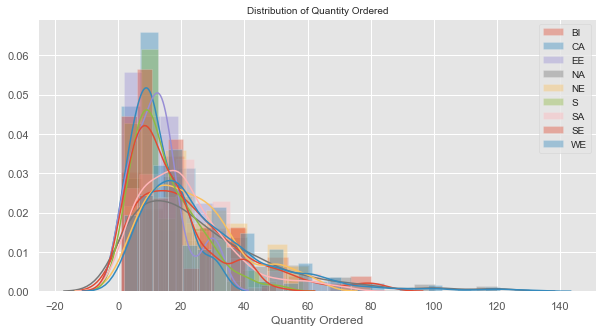

In [45]:
plt.figure(figsize = (10,5))
sns.distplot(BI.Quantity, label = "BI")
sns.distplot(CA.Quantity, label = "CA")
sns.distplot(EE.Quantity, label = "EE")
sns.distplot(NA.Quantity, label = "NA")
sns.distplot(NE.Quantity, label = "NE")
sns.distplot(S.Quantity, label = "S")
sns.distplot(SA.Quantity, label = "SA")
sns.distplot(SE.Quantity, label = "SE")
sns.distplot(WE.Quantity, label = "WE")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

##### Distributions of order quantities by Region to not appear to be Gaussian.  

In [46]:
q2df.Region.value_counts()

Western Europe     736
North America      427
South America      304
British Isles      190
Northern Europe    143
Southern Europe    137
Scandinavia         70
Central America     55
Eastern Europe      16
Name: Region, dtype: int64

In [47]:
for i in [BI, CA, EE, NA, NE, S, SA, SE, WE]:
    print(stats.normaltest(i.Quantity))

NormaltestResult(statistic=41.20964825972506, pvalue=1.1257412494490523e-09)
NormaltestResult(statistic=5.227258641733324, pvalue=0.07326814702099883)
NormaltestResult(statistic=2.85771466977834, pvalue=0.2395825284902985)
NormaltestResult(statistic=135.5391214240316, pvalue=3.6987394699448064e-30)
NormaltestResult(statistic=12.515701339906958, pvalue=0.0019153581124284672)
NormaltestResult(statistic=16.2575615239265, pvalue=0.00029492756859355945)
NormaltestResult(statistic=60.88963734985063, pvalue=5.997679395462476e-14)
NormaltestResult(statistic=21.06008924451824, pvalue=2.6721431883985708e-05)
NormaltestResult(statistic=267.16931245173646, pvalue=9.658750198147336e-59)


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


#### stats normaltest confirms the distributions are not normal<br>Lets re-sample to gather distribution means that will satisfy normality assumptions

In [48]:
#resample data for each region

norm_BI = create_sample_distribution(BI.Quantity, dist_size=40, n=5)
norm_CA = create_sample_distribution(CA.Quantity, dist_size=40, n=5)
norm_EE = create_sample_distribution(EE.Quantity, dist_size=40, n=5)
norm_NA = create_sample_distribution(NA.Quantity, dist_size=40, n=5)
norm_NE = create_sample_distribution(NE.Quantity, dist_size=40, n=5)
norm_S = create_sample_distribution(S.Quantity, dist_size=40, n=5)
norm_SA = create_sample_distribution(SA.Quantity, dist_size=40, n=5)
norm_SE = create_sample_distribution(SE.Quantity, dist_size=40, n=5)
norm_WE = create_sample_distribution(WE.Quantity, dist_size=40, n=5)


In [49]:
type(norm_BI)

list

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


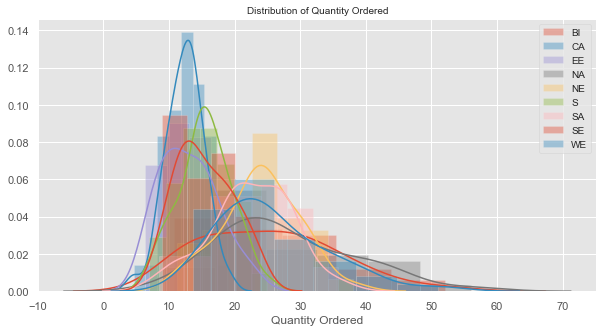

In [50]:
plt.figure(figsize = (10,5))
sns.distplot(norm_BI, label = "BI")
sns.distplot(norm_CA, label = "CA")
sns.distplot(norm_EE, label = "EE")
sns.distplot(norm_NA, label = "NA")
sns.distplot(norm_NE, label = "NE")
sns.distplot(norm_S, label = "S")
sns.distplot(norm_SA, label = "SA")
sns.distplot(norm_SE, label = "SE")
sns.distplot(norm_WE, label = "WE")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [51]:
for i in [norm_BI, norm_CA, norm_EE, norm_NA, norm_NE, norm_S, norm_SA, norm_SE, norm_WE]:
    print(stats.normaltest(i))

NormaltestResult(statistic=2.0250737533191336, pvalue=0.3632961719627318)
NormaltestResult(statistic=1.04012430862409, pvalue=0.5944835971028783)
NormaltestResult(statistic=1.9230055409558142, pvalue=0.38231791798053705)
NormaltestResult(statistic=3.730770891149525, pvalue=0.1548365173311138)
NormaltestResult(statistic=0.11020551384585997, pvalue=0.9463878950488714)
NormaltestResult(statistic=0.002142865853685886, pvalue=0.9989291408524751)
NormaltestResult(statistic=0.6580184752239099, pvalue=0.7196363689948453)
NormaltestResult(statistic=4.011847555236713, pvalue=0.13453595696777013)
NormaltestResult(statistic=8.48151437672719, pvalue=0.014396686711361776)


In [52]:
norm_BI=pd.Series(norm_BI, name= 'norm_BI')
norm_CA=pd.Series( norm_CA, name= 'norm_CA')
norm_EE=pd.Series( norm_EE, name= 'norm_EE')
norm_NA=pd.Series( norm_NA, name= 'norm_NA')
norm_NE=pd.Series( norm_NE, name= 'norm_NE')
norm_S=pd.Series( norm_S, name=  'norm_S')
norm_SA=pd.Series( norm_SA, name= 'norm_SA')
norm_SE=pd.Series( norm_SE, name= 'norm_SE')
norm_WE=pd.Series( norm_WE, name= 'norm_WE')


### combining multiple Series into a DataFrame: <br>lessons learned -- the Series must have names (see example above)<br>and you must specify the horizontal axis



In [53]:
regions_df = pd.DataFrame(pd.concat([norm_BI, norm_CA, norm_EE, norm_NA, norm_NE, norm_S, norm_SA, norm_SE, norm_WE], 
                                   axis = 1))

<a id='link_to_cell_in_question'></a>


### need to run ANOVA here

In [54]:
regions_df.head()

,norm_BI,norm_CA,norm_EE,norm_NA,norm_NE,norm_S,norm_SA,norm_SE,norm_WE
0,25.0,9.6,8.4,41.8,31.2,7.0,29.4,11.2,31.6
1,44.4,11.0,17.4,23.8,18.4,18.8,33.6,23.8,17.2
2,33.6,16.0,11.0,22.4,24.6,11.6,20.8,14.2,39.8
3,15.4,13.6,11.2,35.4,26.2,11.8,26.6,14.8,31.0
4,13.8,17.0,14.8,26.8,23.8,18.8,24.8,22.0,23.6


In [55]:
norm_regions_df = copy.deepcopy(regions_df)
norm_regions_df.head()

,norm_BI,norm_CA,norm_EE,norm_NA,norm_NE,norm_S,norm_SA,norm_SE,norm_WE
0,25.0,9.6,8.4,41.8,31.2,7.0,29.4,11.2,31.6
1,44.4,11.0,17.4,23.8,18.4,18.8,33.6,23.8,17.2
2,33.6,16.0,11.0,22.4,24.6,11.6,20.8,14.2,39.8
3,15.4,13.6,11.2,35.4,26.2,11.8,26.6,14.8,31.0
4,13.8,17.0,14.8,26.8,23.8,18.8,24.8,22.0,23.6


link to pd.melt

<a id='link_to_pd.melt'></a>

In [77]:
q2_transformed_df = pd.melt(norm_regions_df)
q2_transformed_df.head()

,variable,value
0,norm_BI,25.0
1,norm_BI,44.4
2,norm_BI,33.6
3,norm_BI,15.4
4,norm_BI,13.8


In [78]:
q2_transformed_df.rename( columns = {"value":"Quantity", "variable":"Region"}, inplace = True)
q2_transformed_df.head()

,Region,Quantity
0,norm_BI,25.0
1,norm_BI,44.4
2,norm_BI,33.6
3,norm_BI,15.4
4,norm_BI,13.8


In [80]:
q2_transformed_df = pd.get_dummies(q2_transformed_df, columns = ["Region"])


In [83]:
q2_transformed_df.head()

,Quantity,Region_norm_BI,Region_norm_CA,Region_norm_EE,Region_norm_NA,Region_norm_NE,Region_norm_S,Region_norm_SA,Region_norm_SE,Region_norm_WE
0,25.0,1,0,0,0,0,0,0,0,0
1,44.4,1,0,0,0,0,0,0,0,0
2,33.6,1,0,0,0,0,0,0,0,0
3,15.4,1,0,0,0,0,0,0,0,0
4,13.8,1,0,0,0,0,0,0,0,0


##### Lets use an ANOVA test to compare the different groups with the control

In [60]:
formula = "Quantity ~ Region_norm_BI + Region_norm_CA + Region_norm_EE + Region_norm_NA + Region_norm_NE + Region_norm_S \
            + Region_norm_SA + Region_norm_SE + Region_norm_WE"
           
lm = ols(formula, q2_transformed_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                      sum_sq     df          F        PR(>F)
Region_norm_BI   2171.523640    1.0  48.021086  2.026823e-11
Region_norm_CA   1467.406562    1.0  32.450237  2.589822e-08
Region_norm_EE   1163.951506    1.0  25.739630  6.345084e-07
Region_norm_NA   4125.643191    1.0  91.234497  2.272360e-19
Region_norm_NE   1530.736899    1.0  33.850725  1.341221e-08
Region_norm_S     313.003191    1.0   6.921754  8.890719e-03
Region_norm_SA    854.756000    1.0  18.902079  1.805117e-05
Region_norm_SE    328.611955    1.0   7.266927  7.361796e-03
Region_norm_WE   2555.805888    1.0  56.519106  4.688680e-13
Residual        15872.294000  351.0        NaN           NaN


| Region          	| Code 	|
|-----------------	|------	|
| Western Europe  	| WE    	|
| North America   	| NA   	|
| South America   	| SA   	|
| British Isles   	| BI   	|
| Northern Europe 	| NE   	|
| Southern Europe 	| SE   	|
| Scandinavia     	| S   	|
| Central America 	| CA    	|
| Eastern Europe  	| EE   	|

##### Conclusion Question 2 <br>
**restate the question and hypotheses:**<br>
 Is there a region that outperforms the others in terms of order quantities?<br>
𝐻𝑂: each region sells the same quantities of product<br>
𝐻𝑎: regions do not sell the same quantities of product<br>

From the above ANOVA table, we see that we have significant events for all regions and that Western Europe has the greatest variability from the average for all regions.


## <font color='lime'> Question 3 </font>
#### are there any salespeople that stand out?

$H_O$: all sales peoples performance are identical <br>
$H_a$: some sales people do better than others and some do worse<br>

this is a two tailed test

pull the features we need into a dataframe

In [61]:
q3df.EmployeeId.value_counts

NameError: name 'q3df' is not defined

we can use all the data here

EmployeeId is already numeric so, can skip label encoding and go straight to get dummies

Check each group in the feature for normality

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==1], label = "emp1")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==2], label = "emp2")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==3], label = "emp3")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==4], label = "emp4")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==5], label = "emp5")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==6], label = "emp6")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==7], label = "emp7")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==8], label = "emp8")
sns.distplot(q3df['Quantity'][q3df['EmployeeId']==9], label = "emp9")


plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [ ]:
q3_feature_regions = [q3df['Quantity'][q3df['EmployeeId']==1], q3df['Quantity'][q3df['EmployeeId']==2], q3df['Quantity'][q3df['EmployeeId']==3], q3df['Quantity'][q3df['EmployeeId']==4],
                      q3df['Quantity'][q3df['EmployeeId']==5], q3df['Quantity'][q3df['EmployeeId']==6], q3df['Quantity'][q3df['EmployeeId']==7], q3df['Quantity'][q3df['EmployeeId']==8],
                      q3df['Quantity'][q3df['EmployeeId']==9]]


In [ ]:
for i in q3_feature_regions:
    print(stats.normaltest(i))

the histogram and stats normal test confirm the data is normal and there is no need to transform

In [ ]:
q3df = (pd.get_dummies(q3df, columns = ["EmployeeId"])) # one-hot-encode

In [ ]:
q3df.head(2)

In [ ]:
formula = "Quantity ~ C(EmployeeId_1) + C(EmployeeId_2) + C(EmployeeId_3) + C(EmployeeId_4) + C(EmployeeId_5) + C(EmployeeId_6)\
+ C(EmployeeId_7) + C(EmployeeId_8) + C(EmployeeId_9)"
           
lm = ols(formula, q3df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

In [ ]:
q3table = pd.DataFrame(['Emp1', 'Emp2', 'Emp3', 'Emp4', 'Emp5', 'Emp6', 'Emp7', 'Emp8', 'Emp9'])
q3table.columns = ["Employee"]
q3table["Performance Vs Mean"] = [1, 8.6, 7, 3.25, 4.8, 0.5, 17.6, 0.6, 3.5]
q3table.head()

In [ ]:
sns.set(rc={'figure.figsize':(16,8.27)})
plt.style.use('ggplot')

ax = sns.barplot(x= "Employee", y="Performance Vs Mean", data=q3table)

##### Conclusion Question 3 <br> 

**Restate the question and hypotheses:**<br>
 are there any salespeople that stand out?<br>
 
𝐻𝑂: all sales peoples performance are identical <br>
𝐻𝑎: some sales people do better than others and some do worse<br>

We don't have sufficient evidence to say anything about employees 1, 4, 6 or 8. 
We do have significant events for employees 2, 3, 5, 7 and 9.  

Employee seven looks like a superstar on paper but we need to dig deeper to make sure it is her work that is creating the success and not some kind of 'gift' such as being the only salesperson in a region that needs several, or stable and high-growth company she has been relying on, ie, can this person reproduce the results anywhere?  maybe they can distribute some wisdom to our other salespeople. 

## <font color='lime'> Question 4 </font>
#### are there any categories we should think about dicontinuing or expanding on?

$H_O$: orders of categories are equal in quantity <br>
$H_a$: orders by category are not equal<br>

this is a two tailed test

In [ ]:
q4df = data[["Quantity", "CategoryId"]]
q4df.CategoryId.value_counts()

In [ ]:
q4df.head()

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(q4df['Quantity'][q4df['CategoryId']==1], label = "Cat1")
sns.distplot(q4df['Quantity'][q4df['CategoryId']==2], label = "Cat2")
sns.distplot(q4df['Quantity'][q4df['CategoryId']==3], label = "Cat3")
sns.distplot(q4df['Quantity'][q4df['CategoryId']==4], label = "Cat4")
sns.distplot(q4df['Quantity'][q4df['CategoryId']==5], label = "Cat5")
sns.distplot(q4df['Quantity'][q4df['CategoryId']==6], label = "Cat6")
sns.distplot(q4df['Quantity'][q4df['CategoryId']==7], label = "Cat7")



plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [ ]:
q4_feature_regions = [q4df['Quantity'][q4df['CategoryId']==1], q4df['Quantity'][q4df['CategoryId']==2], q4df['Quantity'][q4df['CategoryId']==3], q4df['Quantity'][q4df['CategoryId']==4],
                      q4df['Quantity'][q4df['CategoryId']==5], q4df['Quantity'][q4df['CategoryId']==6], q4df['Quantity'][q4df['CategoryId']==7], ]

In [ ]:
for i in q4_feature_regions:
    print(stats.normaltest(i))

feature regions are normal

In [ ]:
q4df = copy.deepcopy(pd.get_dummies(q4df, columns = ["CategoryId"])) # one-hot-encode

In [ ]:
q4df.head()

In [ ]:
formula = "Quantity ~ C(CategoryId_1) + C(CategoryId_2) + C(CategoryId_3) + C(CategoryId_4) + C(CategoryId_5) + C(CategoryId_6)\
+ C(CategoryId_7) + C(CategoryId_8) "
           
lm = ols(formula, q4df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

| 1 	| Beverages      	|
|---	|----------------	|
| 2 	| Condiments     	|
| 3 	| Confections    	|
| 4 	| Dairy Products 	|
| 5 	| Grains/Cerials 	|
| 6 	| Meet/Poultry   	|
| 7 	| Produce        	|
| 8 	| Seafood        	|

we have significant events for all categories exept for grains/cerials and produce.

In [ ]:
q4table = pd.DataFrame(["Beverages", "Condiments", "Confections", "Dairy Products", "Grains/Cerials", "Meat/Poultry",
                        "Produce", "Seafood" ])

q4table.columns = ["Category"]
q4table["Sales vs Avg"] = [5.6, 8, 6.5, 15, 3, 5.7, 0.4, 6]
q4table.head()

In [ ]:
sns.set(rc={'figure.figsize':(16,8.27)})
plt.style.use('ggplot')

ax = sns.barplot(x= "Category", y="Sales vs Avg", data=q4table)

##### Conclusion Question 4 <br>

**Restate the question and hypotheses:**<br>
are there any categories we should think about dicontinuing or expanding on?<br>

𝐻𝑂: orders of categories are equal in quantity <br>
𝐻𝑎: orders by category are not equal <br>

The test fails to reject the null for category 5 and 7; these seem to be categories with moderate sales.
We can reject the null for categories 1, 2, 3, 4, 6 and 8.  Category 4 especially stands out with the lowest P-value and highest test statistic.  We should further inspect this product and look to duplicate its success. 